### Relationships Between Variables
Two variables are related if knowing one (independent variable; x) gives you information about the other (dependent variable; y). For example, height and weight are related; taller people tend to be heavier.

#### Scatter Plots
A **scatter plot** is the simplest graph used to compare two variables.

Let's compare heights and weights of people in the CDC Demographic data:

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (12, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78"])
rcParams["axes.facecolor"] = "#1A202C"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_pickle("cdc_demographic_2008-clean.pkl")
df.head()

,Age,Gender,Weight_kg_1yr,finalwt,Weight_kg,Height_cm
0,82.0,F,76.363636,185.870345,70.91,157.0
1,65.0,F,72.727273,126.603027,72.73,163.0
2,48.0,F,NaN,181.063210,NaN,165.0
3,61.0,M,73.636364,517.926275,73.64,170.0
4,26.0,M,88.636364,1252.624630,88.64,185.0


C:\Users\markm\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\markm\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weight_kg', ylabel='Density'>

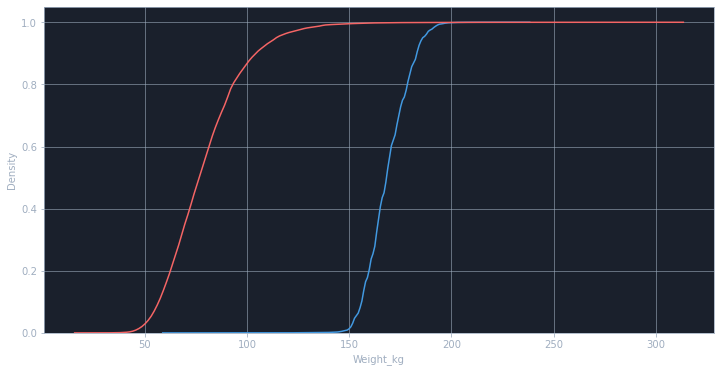

In [3]:
heights = df["Height_cm"]
weights = df["Weight_kg"]

sns.distplot(heights, hist=False, kde_kws={"cumulative": True})
sns.distplot(weights, hist=False, kde_kws={"cumulative": True})

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

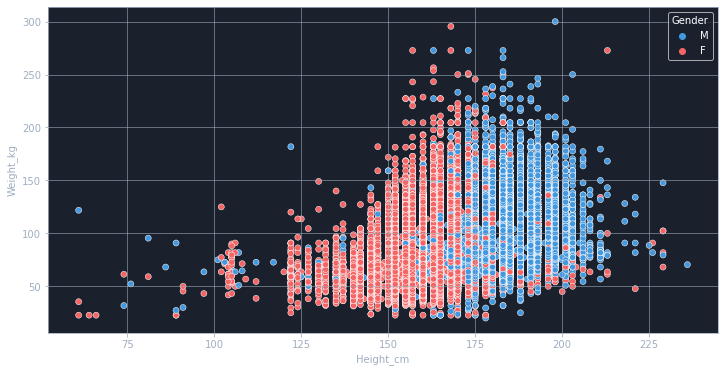

In [4]:
sns.scatterplot(x="Height_cm", y="Weight_kg", hue="Gender", hue_order=["M", "F"], data=df)

Since Seaborn *scatterplot* doesn't support jitter yet, we can also use *regplot* without fitting a linear regression model, adding jitter, and making it basically a scatter plot.

However, we can't use the `hue` parameter to separate the plot by **Gender**.

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

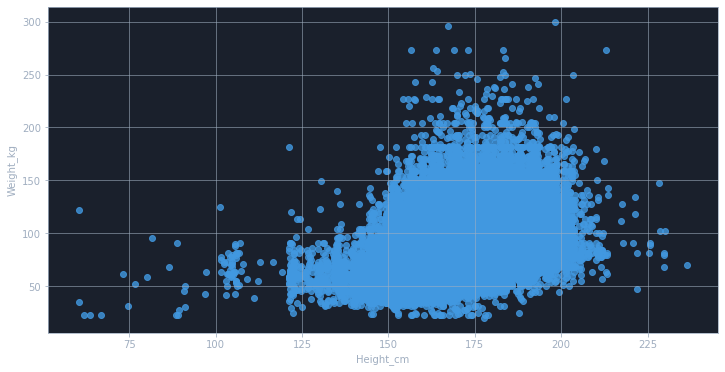

In [5]:
sns.regplot(x="Height_cm", y="Weight_kg", scatter=True, fit_reg=False, x_jitter=True, data=df)

We can also create our own `Jitter` function, and jitter each variable to reduce the visual effect of rounding.

However, jittering data should only be used for visualization and not for analysis, because it will introduce a lot of inaccuracies due to noise.

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

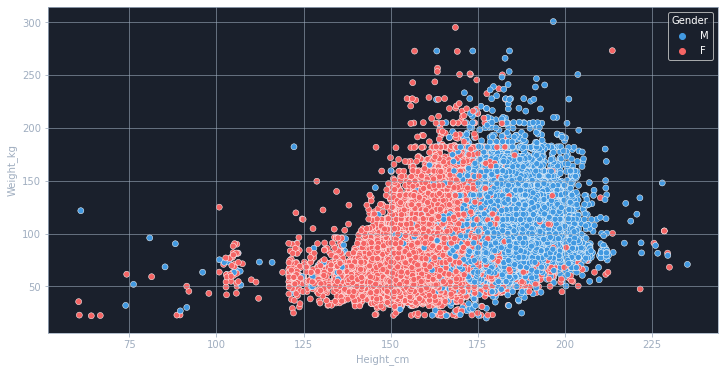

In [6]:
def Jitter(values, jitter=0.5):
    return np.random.uniform(-jitter, jitter, len(values)) + values

sns.scatterplot(x=Jitter(heights, 1.3), y=Jitter(weights), hue=df["Gender"], hue_order=["M", "F"])

Even with jittering, it's still quite hard to interpret this plot due to many overlapping points, which gives disproportionate emphasis to outliers, called **saturation**. We can use the `alpha` parameter to make the points a bit more transparent. We can also remove the edge line for each plot points.

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

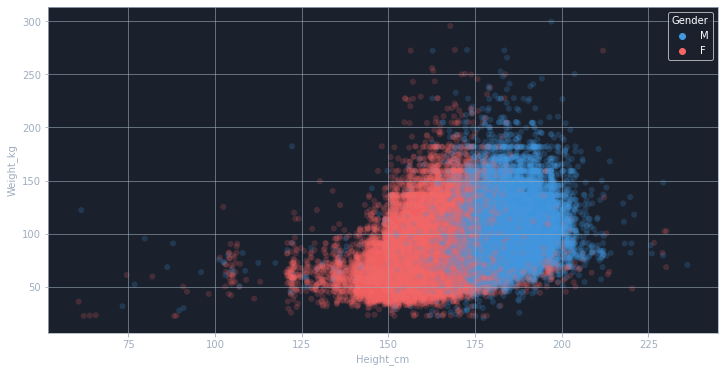

In [7]:
sns.scatterplot(x=Jitter(heights, 1.3), y=Jitter(weights), hue=df["Gender"], hue_order=["M", "F"], alpha=0.2, linewidth=0)

To handle larger datasets, we can also use a hexbin plot, using Seaborn's *jointplot* and setting its `kind` parameter to "hex". This plot will divide the graph into hexagonal bins and the darker the hexagon, the more points fall in that hexagon.

Hexbin plots show the shape of the relationship well. However, it makes outliers invisible.

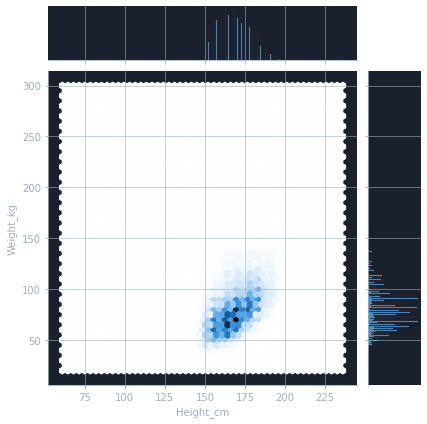

In [8]:
sns.jointplot(x="Height_cm", y="Weight_kg", kind="hex", data=df)

#### Characterizing Relationships
Another way to show the relationship of two variables is by binning one variable and plotting percentiles of the other.

In [9]:
df = df.dropna(subset=["Height_cm", "Weight_kg"])
bins = np.arange(135, 210, 5)

# Gives an index for each height which will determine which group it should go into
indices = np.digitize(df["Height_cm"], bins)

# Groups values based on the indices
groups = df.groupby(indices)

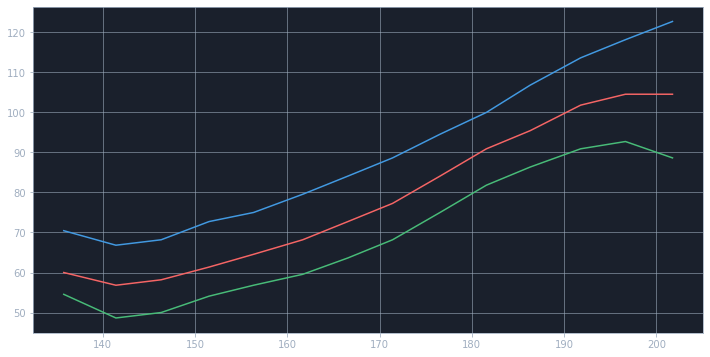

In [10]:
import bisect

def Percentile(sample, percentileRank):
    # First, create a dictionary with the key as the unique values, 
    # and the value as the amount of those unique values
    d = {}
    d.update(sample.value_counts().iteritems())
    
    # Now, we unwrap that dictionary (sorted by key) using zip
    xs, freqs = zip(*sorted(d.items()))
    
    # We make the xs (the unique values) as a numpy array
    # We make the ps the cumulative sum of the freqs (the amount of unique values)
    xs = np.asarray(xs)
    ps = np.cumsum(freqs)
    
    # This normalizes the cumulative sums to the range [0, 1]
    ps = ps / ps[-1]
    
    # Determine which value is associated with the given percentile rank
    index = bisect.bisect_left(ps, percentileRank)
    return xs[index]

heights = [group["Height_cm"].mean() for i, group in groups]

for percent in [75, 50, 25]:
    weights = [Percentile(group["Weight_kg"], percent / 100) for i, group in groups]
    # Array slicing here is needed if we want the same result as in the Think Stats chapter
    plt.plot(heights[1:15], weights[1:15])

#### Correlation
A **correlation** is a statistic for quantifying how related the two variables are to each other. However, oftentimes variables don't have the same units, or come from different distributions. 

The first way to solve these problems is by transforming each value to a **standard score**, or the number of standard deviations from the mean. This transform leads to the *"Pearson product-moment correlation coefficient"*. This is how it looks like when graphed:

Pearson product-moment correlation coefficient: 0.5087364789734584


<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

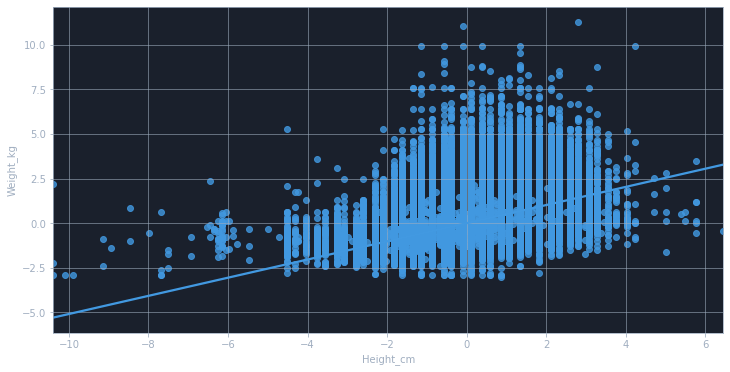

In [11]:
def ToStandardScores(sample):
    mean = sample.mean()
    std = sample.std()
    return (sample - mean) / std

def ToStandardScoreCoefficient(xSample, ySample):
    xMean = xSample.mean()
    yMean = ySample.mean()
    numerator = np.dot(xSample - xMean, ySample - yMean) # same as np.sum((xSample - xMean) * (ySample - yMean))
    denominator = np.sqrt(np.sum(np.power(xSample - xMean, 2)) * np.sum(np.power(ySample - yMean, 2)))
    return numerator / denominator
    # return xSample.corr(ySample, method="pearson")

print("Pearson product-moment correlation coefficient:", ToStandardScoreCoefficient(df["Height_cm"], df["Weight_kg"]))
sns.regplot(x=ToStandardScores(df["Height_cm"]), y=ToStandardScores(df["Weight_kg"]))

According to this plot, because the slope of the linear regression line is positive `(0.5087)`, the heights and weights have a strong positive relationship.

If the slope of the line is 0, then there's no relationship at all. If the slope of the line is negative, then there's a strong negative relationship.

However, it is more robust to use percentile ranks, because with the standard scores, if the sample is skewed or has outliers, the standard score set also does.

The second way is by transforming each value to their **rank**, which is their index in the sorted sample. This transform leads to the *"Spearman rank correlation coefficient"*. This is how it looks like when graphed:

Spearman rank correlation coefficient: 0.5405846262320477


<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

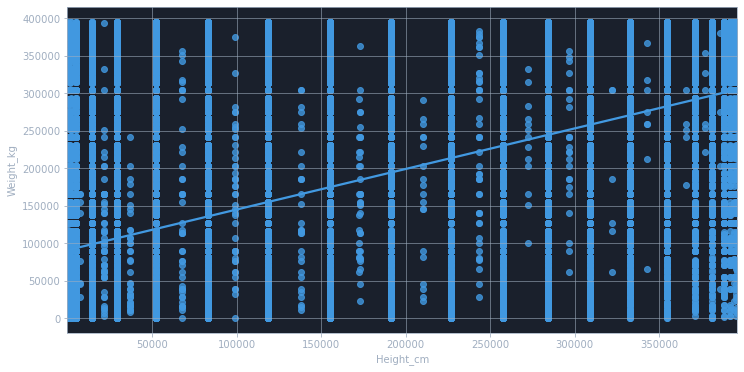

In [12]:
def ToRankScores(sample):
    return sample.rank()

def ToRankCoefficient(xSample, ySample):
    # uses the Pearson correlation coefficient, but over the rank variables
    return ToStandardScoreCoefficient(ToRankScores(xSample), ToRankScores(ySample))
    # return xSample.corr(ySample, method="spearman")

print("Spearman rank correlation coefficient:", ToRankCoefficient(df["Height_cm"], df["Weight_kg"]))
sns.regplot(x=ToRankScores(df["Height_cm"]), y=ToRankScores(df["Weight_kg"]))

According to this plot, because the slope of the linear regression line is positive `(0.5406)`, the heights and weights have a strong positive relationship.

#### Covariance
**Covariance** is the measure of the tendency of two variables to vary together. It is calculated as such:

In [13]:
def Covariance(xSample, ySample):
    xMean = xSample.mean()
    yMean = ySample.mean()
    return np.dot(xSample - xMean, ySample - yMean) / xSample.count()

Covariance(df["Height_cm"], df["Weight_kg"])

103.3329085769776

However, covariance is not reportend in summary statistic because it is hard to interpret. Furthermore, its units are the product of the units of the x and y samples. In the example above, the unit would be *kilogram-centimeters*, which doesn't make sense.

A solution to the unit problem is to divide the deviations by the standard deviation, similar to getting the standard score earlier. It could also be calculated by getting the covariance of the two samples, and dividing them by the product of the standard deviations of the two samples. The resulting value is called the **Pearson's correlation**. Here are the two methods in action:

In [14]:
def Pearson_StdScore(xSample, ySample):
    xStdScores = ToStandardScores(xSample)
    yStdScores = ToStandardScores(ySample)
    return np.dot(xStdScores, yStdScores) / xSample.count()

def Pearson_Covariance(xSample, ySample):
    covariance = Covariance(xSample, ySample)
    stds = xSample.std() * ySample.std()
    return covariance / stds

print(Pearson_StdScore(df["Height_cm"], df["Weight_kg"]))
print(Pearson_Covariance(df["Height_cm"], df["Weight_kg"]))

0.508735193740317
0.5087351937403165


Because the standard scores are dimensionless, so is the resulting value. Pearson's correlation is always in the range `[-1,1]`. If the value is positive, the correlation is positive (when one variable is high, the other also tends to be high). If the value is negative, the correlation is negative (when one variable is high, the other tends to be low).

The magnitude of the value indicates the strength of the correlation. If the value is either 1 or -1, the variables are perfectly correlated (when you know one, you can make a perfect prediction about the other).

**Note: This has actually been calculated previously, using the `ToStandardScoreCoefficient()` method before. However, the previous method is a more verbose version following the given equation in the Think Stats chapter, while these two new functions use numpy and panda's built-in functions to calculate the same thing. These two new functions should be used over the old one for increased readability, however the old one is there to know what really is going on under the hood.**

#### Nonlinear Relationships
If Pearson's correlation is near 0, it is not always the case that there is no relationship between variables. Pearson's correlation only measures *linear* relationships and doesn't apply on *nonlinear* relationships.

**Note: Always look at the scatter plot of the data before blindly computing a correlation coefficient.**

#### Spearman's Rank Correlation
Pearson's correlation works well if the relationship between variables is linear and if the CDF of the variables themselves have roughly a normal distribution. However, it is not robust when it comes to outliers either.

Spearman's rank correlation mitigates the effects of outliers and skewed distributions. The necessary code and plots have already been done above.

#### Correlation and Causation
If variables A and B are correlated, there are three possible explanations:
- A causes B
- B causes A
- some other set of factors causes both A and B

These three are called **causal relationships**.

Correlation alone does not distinguish between these explanations, so it does not tell you which ones out of the three are true. This rule is often summarized with the phrase *"Correlation does not imply causation"*.

What can you do to provide evidence of causation?
- Use time. If A comes before B, then A *can* cause B but not the other way around. The order of events can help us infer the direction of causation (eliminates either "A causes B" or "B causes A"), but it does not eliminate the possibility that something else causes both A and B.
- Use randomness. If you divide a large sample into two groups at random and compute the means of almost any variable, you expect the difference to be small, as shown below:

In [33]:
# Dividing the entire data set into 2 evenly sized subsets
sample1 = df.sample(frac=0.5)
sample2 = df.drop(sample1.index)

print("Difference of Variable Means")
print("\tAge:")
print("\t\tSample 1 mean:", sample1["Age"].mean())
print("\t\tSample 2 mean:", sample2["Age"].mean())
print("\t\tDifference:", np.abs(sample1["Age"].mean() - sample2["Age"].mean()))
print("\tHeight_cm:")
print("\t\tSample 1 mean:", sample1["Height_cm"].mean())
print("\t\tSample 2 mean:", sample2["Height_cm"].mean())
print("\t\tDifference:", np.abs(sample1["Height_cm"].mean() - sample2["Height_cm"].mean()))
print("\tWeight_kg:")
print("\t\tSample 1 mean:", sample1["Weight_kg"].mean())
print("\t\tSample 2 mean:", sample2["Weight_kg"].mean())
print("\t\tDifference:", np.abs(sample1["Weight_kg"].mean() - sample2["Weight_kg"].mean()))
print("\tWeight_kg_1yr:")
print("\t\tSample 1 mean:", sample1["Weight_kg_1yr"].mean())
print("\t\tSample 2 mean:", sample2["Weight_kg_1yr"].mean())
print("\t\tDifference:", np.abs(sample1["Weight_kg_1yr"].mean() - sample2["Weight_kg_1yr"].mean()))

Difference of Variable Means
	Age:
		Sample 1 mean: 54.87412637175519
		Sample 2 mean: 54.908283828215126
		Difference: 0.03415745645993695
	Height_cm:
		Sample 1 mean: 168.9682491562077
		Sample 2 mean: 168.94412781179895
		Difference: 0.024121344408740697
	Weight_kg:
		Sample 1 mean: 79.09678823340008
		Sample 2 mean: 78.99203864266595
		Difference: 0.10474959073413004
	Weight_kg_1yr:
		Sample 1 mean: 79.83734142129599
		Sample 2 mean: 79.69642806089922
		Difference: 0.14091336039676605


If the groups are nearly identical in all variables **but one**, you can eliminate spurious (fake) relationships. However, in this case, the groups are nearly identical in **all** variables.